In [ ]:
import pandas as pd
import re
import string
import nltk
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Ensure NLTK stopwords are downloaded
nltk.download('stopwords')

class DatasetLoader:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = pd.read_csv(self.file_path)
        self.tokenizer = None
        self.label_encoder = None

    def clean_text(self, text):
        text = text.lower()  # Convert to lowercase
        text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
        text = re.sub(r"\d+", "", text)  # Remove numbers
        text = re.sub(r"([?.!,¿])", r" ", text)
        text = re.sub(r'\s+', ' ', text).strip()
        text = re.sub(r'@\w+', '', text)  # Remove mentions
        stop_words = set(stopwords.words('english'))
        text = ' '.join([word for word in text.split() if word not in stop_words])
        return text

    def preprocess_data(self):
        self.df['cleaned_sentence'] = self.df['sentence'].astype(str).apply(self.clean_text)
        X = self.df['cleaned_sentence'].values
        y = self.df['emotion'].values

        # Encode labels
        self.label_encoder = LabelEncoder()
        y = self.label_encoder.fit_transform(y)

        # Tokenization and Padding
        max_words = 10000  # Increased vocabulary size
        max_len = 150  # Increased sequence length
        self.tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
        self.tokenizer.fit_on_texts(X)
        X_seq = self.tokenizer.texts_to_sequences(X)
        X_padded = pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')

        return X_padded, y

    def save_preprocessing_objects(self, tokenizer_path, label_encoder_path):
        with open(tokenizer_path, 'wb') as f:
            pickle.dump(self.tokenizer, f)
        with open(label_encoder_path, 'wb') as f:
            pickle.dump(self.label_encoder, f)

class EmotionLSTMModel:
    def __init__(self, max_words=10000, max_len=150):
        self.max_words = max_words
        self.max_len = max_len
        self.model = None

    def build_model(self, num_classes, learning_rate=0.001, lstm_units=128, dense_units=64, dropout_rate=0.5):
        self.model = Sequential([
            Embedding(self.max_words, 128, input_length=self.max_len),
            LSTM(lstm_units, return_sequences=True),
            LSTM(lstm_units),
            Dense(dense_units, activation='relu'),
            Dropout(dropout_rate),
            Dense(num_classes, activation='softmax')
        ])
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return self.model

    def train_model(self, X_train, y_train, X_test, y_test, epochs=10, batch_size=32):
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])
        return history

    def save_model(self, model_path):
        self.model.save(model_path)

    @staticmethod
    def load_trained_model(model_path):
        return load_model(model_path)

class EmotionPredictor:
    def __init__(self, model_path, tokenizer_path, label_encoder_path, max_len=150):
        self.model = load_model(model_path)
        self.max_len = max_len
        with open(tokenizer_path, 'rb') as f:
            self.tokenizer = pickle.load(f)
        with open(label_encoder_path, 'rb') as f:
            self.label_encoder = pickle.load(f)

    def predict_emotion(self, comment_text):
        seq = self.tokenizer.texts_to_sequences([comment_text])
        padded = pad_sequences(seq, maxlen=self.max_len, padding='post', truncating='post')
        prediction = self.model.predict(padded)
        emotion = self.label_encoder.inverse_transform([np.argmax(prediction)])
        return emotion[0]

if __name__ == "__main__":
    file_path = 'combined_emotion.csv'
    tokenizer_path = 'tokenizer_lstm.pkl'
    label_encoder_path = 'label_encoder_lstm.pkl'
    model_path = 'emotion_lstm_model.h5'

    dataset = DatasetLoader(file_path)
    X, y = dataset.preprocess_data()
    dataset.save_preprocessing_objects(tokenizer_path, label_encoder_path)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    emotion_lstm = EmotionLSTMModel()
    model = emotion_lstm.build_model(num_classes=len(set(y)))
    history = emotion_lstm.train_model(X_train, y_train, X_test, y_test)
    emotion_lstm.save_model(model_path)

    plt.plot(history.history['accuracy'], label='Before Tuning')
    plt.plot(history.history['val_accuracy'], label='After Tuning')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('LSTM Model Accuracy Comparison')
    plt.show()

    predictor = EmotionPredictor(model_path, tokenizer_path, label_encoder_path)
    user_comment = "i will kill you"
    cleaned_comment = dataset.clean_text(user_comment)
    predicted_emotion = predictor.predict_emotion(cleaned_comment)
    print(f"Predicted Emotion using LSTM: {predicted_emotion}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\charu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/10


c:\Users\charu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


10569/10569 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.3335 - loss: 1.5880 - val_accuracy: 0.3404 - val_loss: 1.5762 - learning_rate: 0.0010
Epoch 2/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - accuracy: 0.3379 - loss: 1.5766 - val_accuracy: 0.3404 - val_loss: 1.5760 - learning_rate: 0.0010
Epoch 3/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.3388 - loss: 1.5739 - val_accuracy: 0.3404 - val_loss: 1.5759 - learning_rate: 0.0010
Epoch 4/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 134s 13ms/step - accuracy: 0.3385 - loss: 1.5745 - val_accuracy: 0.3404 - val_loss: 1.5758 - learning_rate: 0.0010
Epoch 5/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 151s 14ms/step - accuracy: 0.3370 - loss: 1.5746 - val_accuracy: 0.3404 - val_loss: 1.5759 - learning_rate: 0.0010
Epoch 6/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 159s 15ms/step - accuracy: 0.3381 - loss: 1.5742 - val_accuracy: 0.3404 - val_loss: 1.5759 - learning_rate: 0.0010
Epoch 7/10
10569/10569 ━━━━━━━━━━━━━━━━━━━━ 161s 15ms/step - ac

Epoch 1/15
5285/5285 ━━━━━━━━━━━━━━━━━━━━ 148s 28ms/step - accuracy: 0.3335 - loss: 1.5816 - val_accuracy: 0.3404 - val_loss: 1.5766 - learning_rate: 5.0000e-04
Epoch 2/15
5285/5285 ━━━━━━━━━━━━━━━━━━━━ 191s 25ms/step - accuracy: 0.3400 - loss: 1.5743 - val_accuracy: 0.3404 - val_loss: 1.5761 - learning_rate: 5.0000e-04
Epoch 3/15
5285/5285 ━━━━━━━━━━━━━━━━━━━━ 161s 29ms/step - accuracy: 0.3377 - loss: 1.5764 - val_accuracy: 0.3404 - val_loss: 1.5759 - learning_rate: 5.0000e-04
Epoch 4/15
5285/5285 ━━━━━━━━━━━━━━━━━━━━ 157s 30ms/step - accuracy: 0.3373 - loss: 1.5756 - val_accuracy: 0.3404 - val_loss: 1.5759 - learning_rate: 5.0000e-04
Epoch 5/15
5285/5285 ━━━━━━━━━━━━━━━━━━━━ 146s 28ms/step - accuracy: 0.3380 - loss: 1.5758 - val_accuracy: 0.3404 - val_loss: 1.5759 - learning_rate: 5.0000e-04
Epoch 6/15
5285/5285 ━━━━━━━━━━━━━━━━━━━━ 148s 28ms/step - accuracy: 0.3386 - loss: 1.5747 - val_accuracy: 0.3404 - val_loss: 1.5760 - learning_rate: 1.0000e-04
Epoch 7/15
5285/5285 ━━━━━━━━━━━━━

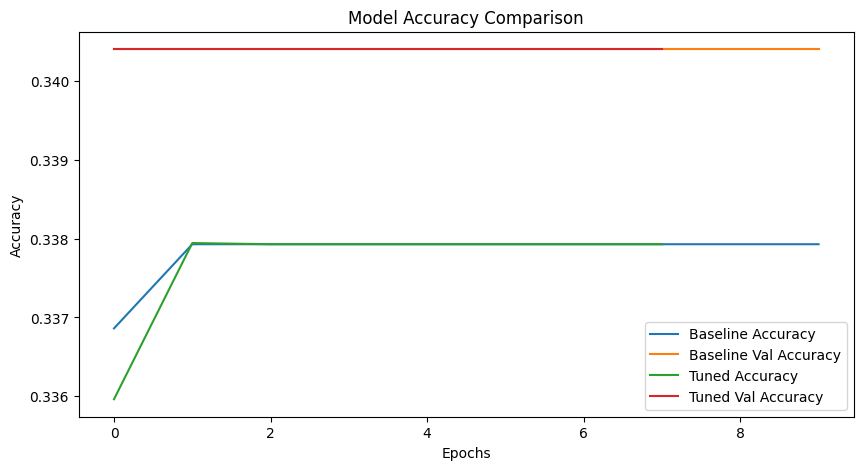

2643/2643 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step


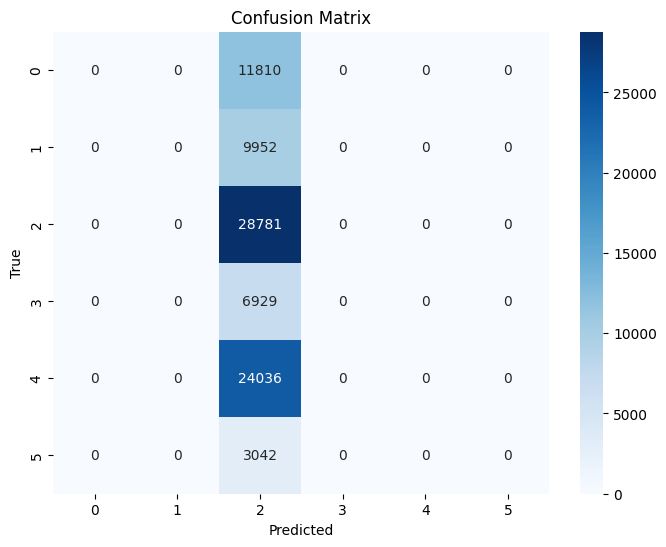

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     11810
           1       0.00      0.00      0.00      9952
           2       0.34      1.00      0.51     28781
           3       0.00      0.00      0.00      6929
           4       0.00      0.00      0.00     24036
           5       0.00      0.00      0.00      3042

    accuracy                           0.34     84550
   macro avg       0.06      0.17      0.08     84550
weighted avg       0.12      0.34      0.17     84550



c:\Users\charu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\charu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\charu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [1]:
import pandas as pd
import re
import string
import nltk
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

nltk.download('stopwords')

class DatasetLoader:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = pd.read_csv(self.file_path)
        self.tokenizer = None
        self.label_encoder = None

    def clean_text(self, text):
        text = text.lower()
        text = re.sub(f"[{string.punctuation}]", "", text)
        text = re.sub(r"\d+", "", text)
        text = re.sub(r"([?.!,¿])", r" ", text)
        text = re.sub(r'\s+', ' ', text).strip()
        text = re.sub(r'@\w+', '', text)
        stop_words = set(stopwords.words('english'))
        text = ' '.join([word for word in text.split() if word not in stop_words])
        return text

    def preprocess_data(self):
        self.df['cleaned_sentence'] = self.df['sentence'].astype(str).apply(self.clean_text)
        X = self.df['cleaned_sentence'].values
        y = self.df['emotion'].values

        self.label_encoder = LabelEncoder()
        y = self.label_encoder.fit_transform(y)

        max_words = 1000
        max_len = 100
        self.tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
        self.tokenizer.fit_on_texts(X)
        X_seq = self.tokenizer.texts_to_sequences(X)
        X_padded = pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')

        return X_padded, y

    def save_preprocessing_objects(self, tokenizer_path, label_encoder_path):
        with open(tokenizer_path, 'wb') as f:
            pickle.dump(self.tokenizer, f)
        with open(label_encoder_path, 'wb') as f:
            pickle.dump(self.label_encoder, f)

class EmotionRNNModel:
    def __init__(self, max_words=1000, max_len=100):
        self.max_words = max_words
        self.max_len = max_len
        self.model = None

    def build_model(self, num_classes, learning_rate=0.001, rnn_units=64, dense_units=64, dropout_rate=0.5):
        self.model = Sequential([
            Embedding(self.max_words, 128, input_length=self.max_len),
            SimpleRNN(rnn_units, activation='relu'),
            Dense(dense_units, activation='relu'),
            Dropout(dropout_rate),
            Dense(num_classes, activation='softmax')
        ])
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return self.model

    def train_model(self, X_train, y_train, X_test, y_test, epochs=10, batch_size=32):
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])
        return history

    def save_model(self, model_path):
        self.model.save(model_path)

if __name__ == "__main__":
    file_path = 'combined_emotion.csv'
    tokenizer_path = 'tokenizer.pkl'
    label_encoder_path = 'label_encoder.pkl'
    model_path = 'emotion_rnn_model.h5'

    dataset = DatasetLoader(file_path)
    X, y = dataset.preprocess_data()
    dataset.save_preprocessing_objects(tokenizer_path, label_encoder_path)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Baseline Model
    emotion_rnn = EmotionRNNModel()
    model = emotion_rnn.build_model(num_classes=len(set(y)))
    history_before = emotion_rnn.train_model(X_train, y_train, X_test, y_test)
    emotion_rnn.save_model(model_path)

    # Tuned Model
    emotion_rnn_tuned = EmotionRNNModel()
    model_tuned = emotion_rnn_tuned.build_model(num_classes=len(set(y)), learning_rate=0.0005, rnn_units=128, dense_units=128, dropout_rate=0.3)
    history_after = emotion_rnn_tuned.train_model(X_train, y_train, X_test, y_test, epochs=15, batch_size=64)
    emotion_rnn_tuned.save_model('emotion_rnn_tuned_model.h5')

    # Plot Accuracy Comparison
    plt.figure(figsize=(10, 5))
    plt.plot(history_before.history['accuracy'], label='Baseline Accuracy')
    plt.plot(history_before.history['val_accuracy'], label='Baseline Val Accuracy')
    plt.plot(history_after.history['accuracy'], label='Tuned Accuracy')
    plt.plot(history_after.history['val_accuracy'], label='Tuned Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy Comparison')
    plt.show()

    # Confusion Matrix
    y_pred = np.argmax(emotion_rnn_tuned.model.predict(X_test), axis=1)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("Classification Report:\n", classification_report(y_test, y_pred))
